In [1]:
import sys
sys.path.insert(0, '/usr/local/lib/python2.7/site-packages/')

import numpy as np
import pandas as pd

In [2]:
def parse_net(input_file='./data/SiouxFalls_net.txt'):
    
    # read raw txt
    fin = open(input_file)
    data = []
    for line in fin:
        data.append(line)
    fin.close()
    
    # prepare fields
    fields = ['init_node',
        'term_node', 
        'capacity', 
        'length', 
        'free_flow', 
        'time', 
        'b', 
        'power', 
        'speed_limit', 
        'toll_type']

    mapper = {}
    for f in fields:
        mapper[f] = int

    for f in ['capacity', 'time']:
        mapper[f] = float
    
    # process lines
    dataset = []
    for line in data[8:]:
        cur_dict = {}
        tokens = line.split()[:-1]
        assert len(tokens)==len(fields)
        for key, value in zip(fields, tokens):
            cur_dict[key] = mapper[key](value)
        dataset.append(cur_dict)
    
    return pd.DataFrame(dataset)


def parse_trips(input_file = './data/SiouxFalls_trips.txt'):
    fin = open(input_file)
    data = []
    for line in fin:
        data.append(line)
    fin.close()

    flows = np.zeros((24, 24))

    for r,i in enumerate(range(6,len(data),7)[:-1]):
        flows[r, 0:5]   = np.array(map(lambda x: float(x[:-1]), data[i+0].split()[2::3]))
        flows[r, 5:10]  = np.array(map(lambda x: float(x[:-1]), data[i+1].split()[2::3]))
        flows[r, 10:15] = np.array(map(lambda x: float(x[:-1]), data[i+2].split()[2::3]))
        flows[r, 15:20] = np.array(map(lambda x: float(x[:-1]), data[i+3].split()[2::3]))
        flows[r, 20:24] = np.array(map(lambda x: float(x[:-1]), data[i+4].split()[2::3]))

    assert np.sum(flows) == 360600.0
    return flows

In [3]:
net_df = parse_net()
d = parse_trips()

In [4]:
f_ = np.zeros((24, 24))
t_ = np.zeros((24, 24))
edges = np.zeros((76, 2))

for k, row in net_df.iterrows():
    i = int(row['init_node']) - 1 # 1-based numeration in source
    j = int(row['term_node']) - 1
    f_[i, j] = row['capacity']
    t_[i, j] = row['free_flow']
    edges[k] = [i, j]

In [5]:
print "sum of f_*t_: {}".format(np.sum([f_[i,j]*t_[i, j] for i,j in edges.astype(int)]))

nu = 1.0 / (4* 24 * f_ *np.log(24+1))
eps = 1e+6
nu = nu * eps

sum of f_*t_: 3054712.13847


In [6]:
def calc_functional(T, edges, d, f_, t_, nu):
    res = 0
    for s in range(24):
        for k in range(24):
            res += -d[s, k] * (T[s, k] - T[s, s])
    #print res
    for i, j in edges.astype(int):
        SoE = np.sum(np.exp((T[:, j] - T[:, i] - t_[i, j])*1.0 / nu[i,j]))
        add_ij = f_[i, j] * nu[i, j] * np.log( 1.0 / 25 * (SoE + 1))
        res += add_ij
        #print SoE
    return res


def calc_F(T, edges, f_, t_, nu):
    res = 0
    #print res
    for i, j in edges.astype(int):
        SoE = np.sum(np.exp((T[:, j] - T[:, i] - t_[i, j])*1.0 / nu[i,j]))
        add_ij = f_[i, j] * nu[i, j] * np.log( 1.0 / 25 * (SoE + 1))
        res += add_ij
        #print SoE
    return res

# Network visualize and generate init point

In [7]:
import networkx as nx

In [8]:
dg = nx.DiGraph()
dg.add_weighted_edges_from([(i, j, t_[i,j]) for i, j in edges.astype(int)])

In [9]:
init_T = np.zeros((24, 24))
for i in range(24):
    for j in range(24):
        init_T[i,j] = nx.algorithms.dijkstra_path_length(dg, i, j)
calc_functional(init_T , edges, d, f_, t_, nu)

-3461613.0094177984

In [11]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
# load coorditanes
pos = {}
for i, row in pd.read_csv('./data/SiouxFalls_node.txt', sep='\t').iterrows():
    pos[i] = np.array((row['X'] *1.0/ 10000, row['Y'] *1.0/ 10000))
    
# draw graph
figsize(18, 18)
labels = nx.draw_networkx_labels(dg, pos)
nx.draw_networkx_nodes(dg, pos)
nx.draw_networkx_edges(dg, pos, arrows=True)
edge_labes = nx.draw_networkx_edge_labels(dg, pos)

Populating the interactive namespace from numpy and matplotlib


# APPROX

In [12]:
def calc_Vs(f_, nu, edges, tau):
    # w_j - number of blocks on which f_j is depend on (f = \sum_j f_j)
    # w_j=2 in our case (i-th and j-th)
    
    # L_{ij, k} -- Lipschitz's constant, 
    #  = f_[i,j]  / nu[i, j], if k==i or k==j
    #  = 0, otherwise
    
    # v_k = \sum beta_ij * L_ij,k
    
    n_blocks = f_.shape[0]
    w = 2
    beta = 1 + (w - 1) * (tau - 1) / max(1, n_blocks - 1) 
    
    
    v = np.zeros(n_blocks)
    for k in range(n_blocks):
        for i, j in edges.astype(int):
            if i==k or j==k:
                L_ijk = f_[i,j]  / nu[i, j]
                v[k] += beta * L_ijk
    return v

In [17]:
def brutal_gradient(k, T, edges, f_, t_, nu):
    value_before = calc_F(T, edges, f_, t_, nu)
    step_size = 0.001
    res = np.zeros(24)
    for i in range(24):
        offset = np.zeros((24, 24))
        offset[i, k] = step_size
        value_after = calc_F(T + offset, edges, f_, t_, nu)
        res[i]  = (value_after - value_before) / step_size
    res[k] = 0
    return res


def blockgrad_f(k, T, edges, f_, t_, nu, S=24):
    '''
    k -- number of block
    T  -- matrix T_ij,
    f_ -- matrix with flow capacity
    nu -- matrix of precalced nu_ij
    edges -- matrix (2, n_edge)
    S -- number of sources
    
    returns vector with N elements
    '''
    assert  T.shape[0]==T.shape[1]
    #assert type(k) == type(1)
    res = np.zeros(T.shape[0])
    
    for i,j in edges.astype(int):
        # skip non-interesting components
        if i!=k and j!=k:
            continue
        # only interesting there, define multiplier
        if i==k: coeff = -1
        if j==k: coeff =  1
        
        exponents = np.exp((T[:, j] - T[:, i] - t_[i, j])*1.0 / nu[i,j])
        res += coeff * f_[i, j] * 1.0 / (np.sum(exponents)+1) * exponents
    # zeroing k-th component
    res[k] = 0
    return res

def argmin_t(k, theta, u, z, n_blocks, v, tau, f_, t_, nu, d):
    w = blockgrad_f(k, theta**2 * u + z, edges, f_, t_, nu, 24)
    #w = brutal_gradient(k, theta**2 * u + z, edges, f_, t_, nu)
    b = n_blocks * theta * v[k] * 1.0 / (2*tau)
    
    t_k = (d[:, k] - w) * 1.0 / (2*b)
    return t_k

## Initialization

In [18]:
tau = 5
n_blocks = 24
v = calc_Vs(f_, nu, edges, tau)

z = init_T *1.0
theta = tau * 1.0 / n_blocks
u = np.zeros((24, 24))

## Main loop

In [19]:
copy_z, copy_u, copy_theta = 0, 0, 0
quality = []

for n_iter in range(5000):
    blocks_set = np.random.choice(range(n_blocks), tau)
    for k in blocks_set:
        t_k = argmin_t(k, theta, u, z, n_blocks, v, tau, f_, t_, nu, d)
        z[:, k] += t_k
        u[:, k] -= ((1 - n_blocks * theta * 1.0 / tau) / theta**2) * t_k
    theta = (np.sqrt(theta**4 + 4*theta**2) - theta**2) / 2
    
    q = calc_functional(theta**2 * u + z, edges, d, f_, t_, nu)
    if np.isnan(q) or np.isinf(q):
        print n_iter, 'ALARM -- NAN'
        break
        
    if n_iter%100==0:
        print n_iter,  q
    copy_z = z
    copy_u = u
    copy_theta = theta
    quality.append(q)

0 -3462875.77537
100 -3678722.57225
200 -3843375.4055
300 -3993880.83209
400 -4160793.1026
500 -4337496.31073
600 -4519434.27828
700 -4719405.54253
800 -4925518.96636
900 -5151816.42763
1000 -5392692.76017
1100 -5661487.87722
1200 -5957810.28828
1300 -6280149.66398
1400 -6625711.20291
1500 -6999861.38078
1600 -7399941.66238
1700 -7817611.55644
1800 -8260611.21362
1900 -8727480.58221
2000 -9212530.61914
2100 -9721147.46997
2200 -10253346.0054
2300 -10807383.5265
2400 -11387389.7998
2500 -11984969.5353
2600 -12604283.3598
2700 -13242638.9808
2800 -13901487.6466
2900 -14585794.7002
2990 ALARM -- NAN


In [20]:
figsize(8, 5)
plot(np.array(quality))

# debug

In [21]:
d[5, 16]

500.0

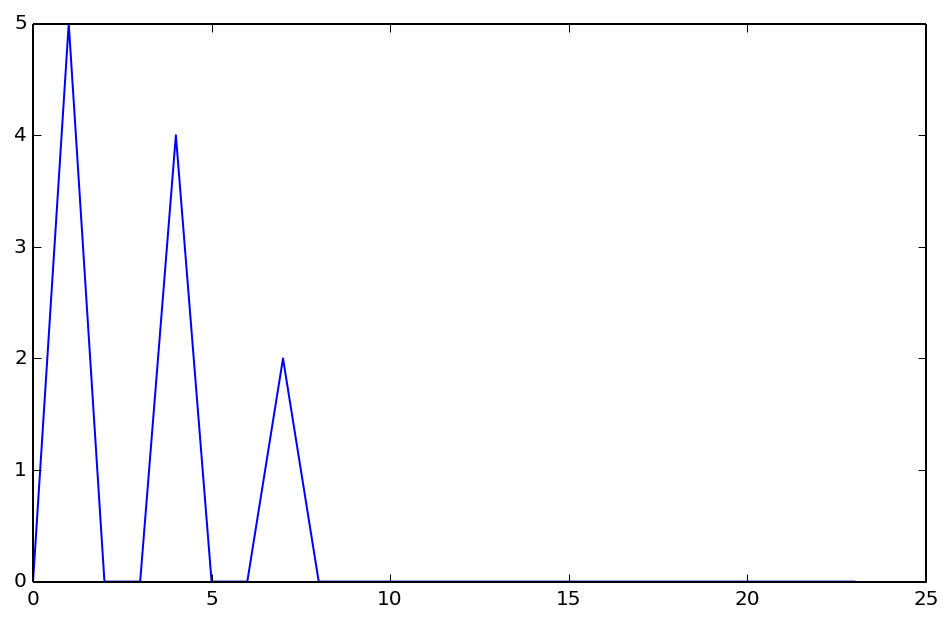

In [22]:
plot(t_[5])

In [23]:
plot((copy_theta ** 2 * copy_u + copy_z)[:, 0])
plot((copy_theta ** 2 * copy_u + copy_z)[:, 1])
plot((copy_theta ** 2 * copy_u + copy_z)[:, 2])
plot((copy_theta ** 2 * copy_u + copy_z)[:, 3])


In [24]:
plot((copy_theta ** 2 * copy_u + copy_z)[:, 5])
plot((copy_theta ** 2 * copy_u + copy_z)[:, 9])
plot((copy_theta ** 2 * copy_u + copy_z)[:, 15])
plot((copy_theta ** 2 * copy_u + copy_z)[:, 16])

In [25]:
T = theta**2 * u + z

In [26]:
i = 9 
j = 16
T = theta**2 * u + z
np.exp((T[:, j] - T[:, i] - t_[i, j])*1.0 / nu[i,j])

array([  1.04766228e+231,   1.48228387e+093,   2.25218188e+042,
         2.17211852e+249,   3.37472667e+095,   4.76614246e+231,
         1.78468162e+214,   3.15198339e+238,   2.09669573e+250,
         1.25758835e+251,   2.39879540e+250,   4.84321908e+249,
         1.81371308e+249,   3.70504750e+222,   8.93790657e+222,
         6.33389505e+212,   2.98884131e-040,   3.12084892e+224,
         1.51739065e+219,   1.11008392e+213,   1.21705152e+222,
         1.28735454e+223,   6.72369849e+221,   1.07483867e+151])

In [27]:
T[0, j] - T[0, i] - t_[i, j]

344.73409937125109

In [28]:
T[0, j]

433.07700514289138

In [29]:
calc_F(theta**2 * u + z, edges, f_, t_, nu)

inf

# Validate

In [30]:
T_ij = copy_theta**2 * copy_u + copy_z

In [31]:
def calc_flow(i, j):
    sum_of_exp = 0.0
    for s in range(24):
        sum_of_exp += np.exp( (T_ij[s,j] - T_ij[s, i] - t_[i,j]) / nu[i,j] )
    return f_[i,j] * sum_of_exp / (sum_of_exp + 1)

flow = np.zeros((24, 24))
for i,j in edges.astype(int):
    flow[i,j] = calc_flow(i, j)

In [32]:
for i in range(24):
    print i, np.sum(flow[:, i]) - np.sum(flow[i, :])

0 -242.181223518
1 -718.229945627
2 -5774.75339016
3 2662.97081104
4 -271.970099001
5 3593.80994726
6 2240.60206117
7 2704.80304214
8 3.8267804392
9 -1217.04105871
10 1236.87601753
11 -870.588654234
12 1597.20698371
13 1519.705701
14 -3334.36159247
15 -inf
16 inf
17 -11525.4815576
18 1814.65589147
19 1008.21690902
20 1124.87744539
21 -0.0931179464787
22 2.49736139763
23 -2.34734312345


In [33]:
np.sum(d[:, 1])

4000.0

In [ ]:
np.sum(d[1, :])

# checks

### -> calc_functional -- OK

### -> gradient -- OK

### -> minimization -- OK

In [34]:
def argmin_t(k, theta, u, z, n_blocks, v, tau, f_, t_, nu, d):
    w = blockgrad_f(k, theta**2 * u + z, edges, f_, t_, nu, 24)
    #w = brutal_gradient(k, theta**2 * u + z, edges, f_, t_, nu)
    b = n_blocks * theta * v[k] * 1.0 / (2*tau)
    
    t_k = (d[:, k] - w) * 1.0 / (2*b)
    return t_k

In [35]:
k = 5
my_t = argmin_t(k, theta, u, z, n_blocks, v, tau, f_, t_, nu, d)

In [36]:
from scipy.optimize import minimize

In [37]:
w = blockgrad_f(k, theta**2 * u + z, edges, f_, t_, nu, 24)
b = n_blocks * theta * v[k] * 1.0 / (2*tau)

def target_f(x, w=w, b=b, k=k, d=d):
    res = np.sum(w*x) + b*np.sum(x*x)
    res += -np.sum(d[:, k] * (z[:, k] + x))
    #res += np.sum(z[k,k]+x[k]*d[k,:])
    return res

In [38]:
target_f(np.zeros(24))

-498366.12704740535

In [39]:
sp_t = minimize(target_f, np.zeros(24))['x']

In [40]:
my_t

array([ 0.07440401,  0.12142074,  0.2891865 , -0.12791111,  0.1530148 ,
        0.        ,  0.39821107,  0.16330899, -0.15867229, -0.00595742,
       -0.04405197,  0.07853215,  0.02705383,  0.1969375 ,  0.25383824,
        0.47524163, -0.03783113,  0.15265675,  0.55160284,  0.27536012,
        0.19927085,  0.72160788,  0.1862652 ,  0.10302281])

In [41]:
sp_t

array([ 0.07440183,  0.12141383,  0.28919009, -0.12790944,  0.15302581,
        0.        ,  0.39820812,  0.16331053, -0.1586824 , -0.00595431,
       -0.04406191,  0.07854278,  0.02706505,  0.19692532,  0.25384313,
        0.47523526, -0.03783694,  0.1526469 ,  0.55159984,  0.27535984,
        0.19927998,  0.72160843,  0.18626169,  0.10302365])

(-0.0001, 0.0001)

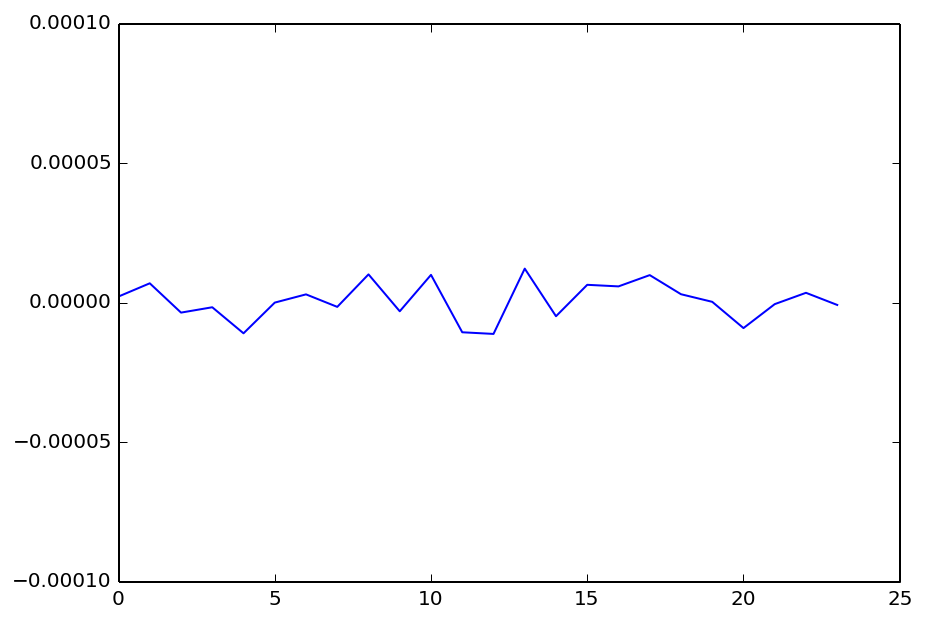

In [42]:
figsize(7, 5)
plot(my_t - sp_t)
ylim(-0.0001, 0.0001)